# Pyrcca: regularized kernel canonical correlation analysis in Python and its applications to neuroimaging.

This notebook contains analyses and the figures for a Pyrcca analysis on a natural movie fMRI dataset described in the following e-print publication:

Bilenko, N.Y. and Gallant, J.L. (2015). Pyrcca: regularized kernel canonical correlation analysis in Python and its applications to neuroimaging. arXiv:1503.01538 [q-bio.QM] http://arxiv.org/abs/1503.01538

Download the Pyrcca code from this GitHub repository:
https://github.com/gallantlab/pyrcca

The dataset used in this notebook is publicly available on on CRCNS:
Nishimoto, S., Vu, A. T., Naselaris, T., Benjamini, Y., Yu, B., Gallant, J. L. (2014): Gallant Lab Natural Movie 4T fMRI Data. CRCNS.org.
http://dx.doi.org/10.6080/K00Z715X

Details of the experiments are described in the original publication about this data:
Nishimoto, S., Vu, A. T., Naselaris, T., Benjamini, Y., Yu, B., and Gallant, J. L. (2011). Reconstructing visual experiences from brain activity evoked by natural movies. Current Biology, 21(19), 1641-1646.

## Simple example

First, we include a simple startup example to show how Pyrcca can be used with random data (described in the Methods and Materials section).

In [1]:
import numpy as np
import rcca

nObservations = 1000

# Define two latent variables
lat_var1 = np.random.randn(nObservations,)
lat_var2 = np.random.randn(nObservations,)

# Define independent signal components
indep1 = np.random.randn(nObservations, 4)
indep2 = np.random.randn(nObservations, 4)

# Define two datasets as a combination of latent variables
# and independent signal components
data1 = indep1 + np.vstack((lat_var1, lat_var1, lat_var2, lat_var1)).T
data2 = indep2 + np.vstack((lat_var1, lat_var1, lat_var2, lat_var1)).T

# Divide data into two halves: training and testing sets
train1 = data1[:nObservations/2]
test1 = data1[nObservations/2:]
train2 = data2[:nObservations/2]
test2 = data2[nObservations/2:]

# Set up Pyrcca
cca = rcca.CCA(kernelcca=False, numCC=2, reg=0.)

# Find canonical components
cca.train([train1, train2])

# Test on held-out data
corrs = cca.validate([test1, test2])

Training CCA, regularization = 0.0000, 2 components


### Visualization

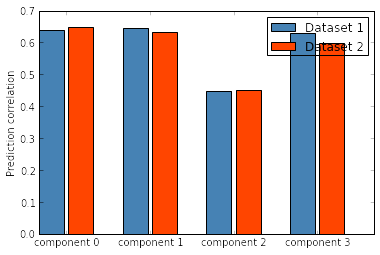

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
f = plt.figure()
ax = f.add_subplot(111)
plot0 = ax.bar(np.arange(corrs[0].shape[0]), corrs[0], 0.3, color = "steelblue")
plot1 = ax.bar(np.arange(corrs[1].shape[0])+0.35, corrs[1], 0.3, color="orangered")
ax.legend([plot0[0], plot1[0]], ["Dataset 1", "Dataset 2"])
ax.set_ylabel("Prediction correlation")
ax.set_xticks(np.arange(corrs[0].shape[0])+0.325)
ax.set_xticklabels(["component %d" % i for i in range(corrs[0].shape[0])])

## Imports for neuroimaging data analysis

In [3]:
import h5py
import rcca
import sys
import numpy as np
zscore = lambda d: (d-d.mean(0))/d.std(0)

## Load data from CRCNS

To run this code, download data from CRCNS: http://crcns.org/data-sets/vc/vim-2
The following analysis assumes that the data are located in a directory inside the current directory nameded "data".

In [4]:
data = []
vdata = []
numSubjects = 3
dataPath ="./data/VoxelResponses_subject%d.mat"
for subj in range(numSubjects):
    f = h5py.File(dataPath % (subj+1),'r')
    datasize = (int(f["ei"]["datasize"].value[2]),int(f["ei"]["datasize"].value[1]),int(f["ei"]["datasize"].value[0]))
    roimat = np.zeros(datasize)
    rois = f["roi"].keys()
    for roi in rois:
        roimat += f["roi"][roi].value
    roimat = roimat>0
    data_subj = np.nan_to_num(zscore(np.nan_to_num(f["rt"].value.T)))
    data.append(data_subj.reshape((data_subj.shape[0],)+datasize)[:, roimat])
    vdata_subj = np.nan_to_num(zscore(np.nan_to_num(f["rv"].value.T)))
    vdata.append(vdata_subj.reshape((vdata_subj.shape[0],)+datasize)[:, roimat])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


## Define CCA parameters

In [5]:
numCCs = np.arange(3, 10)
regs = np.array(np.logspace(-3, 1, 10))
cca = rcca.CCACrossValidate(numCCs=numCCs, regs=regs)

# Run and save the analysis

In [6]:
# NOTE: this analysis is computationally intensive due to the size of data. Running it in the notebook
# would take a considerable amount of time, so we recommend parallelizing it and/or running
# it on a computer cluster, and then loading in the results for visualization.

# cca.train(data)
# cca.validate(data)
# cca.save("./data/CCA_results.hdf5")

### Compute variance explained (computationally intensive)

In [7]:
# cca.compute_ev(vdata)
# cca.save("./data/CCA_results.hdf5")

## Visualize results for one of the subjects

### Plot correlation histogram

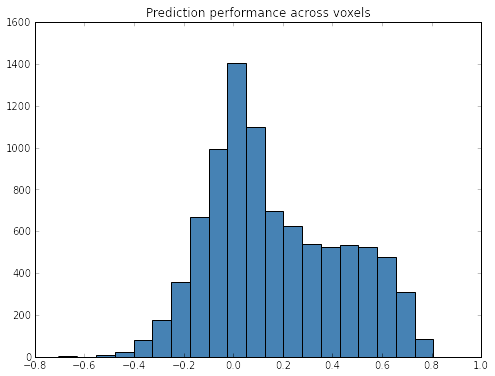

In [8]:
cca = rcca.CCA()
cca.load("./data/CCA_results.hdf5")
%matplotlib inline
import matplotlib.pyplot as plt

f = plt.figure(figsize = (8, 6))
ax = f.add_subplot(111)
ax.hist(cca.corrs[0], bins = 20, color = "steelblue")
ax.set_title("Prediction performance across voxels")

### Plot average correlation for regions of interest

First, load the ROI information for the subject again

In [9]:
f = h5py.File(dataPath % (1),'r')
datasize = (int(f["ei"]["datasize"].value[2]),int(f["ei"]["datasize"].value[1]),int(f["ei"]["datasize"].value[0]))
roimat = np.zeros(datasize)
rois = f["roi"].keys()
for roi in rois:
    roimat += f["roi"][roi].value
roimat = roimat>0

Now, compute the mean correlation and variance for each ROI

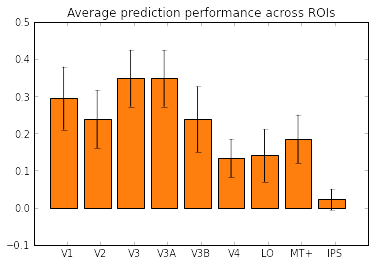

In [10]:
rois = ["V1", "V2", "V3", "V3A", "V3B", "V4", "LO", "MT+", "IPS"]

rois_dict = {"V1": ["v1lh", "v1rh"], "V2": ["v2lh", "v2rh"], "V3": ["v3alh", "v3arh"], "V3A": ["v3alh", "v3arh"], "V3B": ["v3blh", "v3brh"],
             "V4": ["v4lh", "v4rh"], "LO": ["latocclh", "latoccrh"], "IPS": ["IPlh", "IPrh"],
             "MT+": ["MTlh", "MTrh", "MTplh", "MTprh"]}

roimasks = [np.sum(np.array([f["roi"][subroi].value for subroi in rois_dict[roi]]), 0) for roi in rois if roi in rois_dict.keys()]


corrvol = np.zeros(datasize)
corrvol[roimat] = cca.corrs[0]
roimeans = [np.nan_to_num(corrvol[mask>0]).mean() for mask in roimasks]
roivars = [np.nan_to_num(corrvol[mask>0]).var() for mask in roimasks]
f1 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.bar(0.5+np.arange(len(roimeans)), roimeans, yerr = roivars, ecolor = "black", color = "#FF7F0E")
ax1.set_xticks(1.+np.arange(len(roimeans)))
ax1.set_xticklabels(rois)
ax1.set_title("Average prediction performance across ROIs")

### Cortical map plots

To plot correlations, canonical weights, and variance explained per voxel on the cortical surface of the subject, a few manual steps are needed.

First, pycortex software is needed for visualization, available here:
http://pycortex.org/

Then, the subject's anatomical files (available on CRCNS) must be used to create a surface. We recommend Freesurfer:
http://freesurfer.net/

Freesurfer surface can be imported into pycortex and aligned with the functional data. Once this step is complete, the following figures can be made.

Below, it is assumed that the subjName is the pycortex code for subject 1 in the analysis, and subjTransform is the name of the functional-anatomical transform in the pycortex database.

##### Correlation map

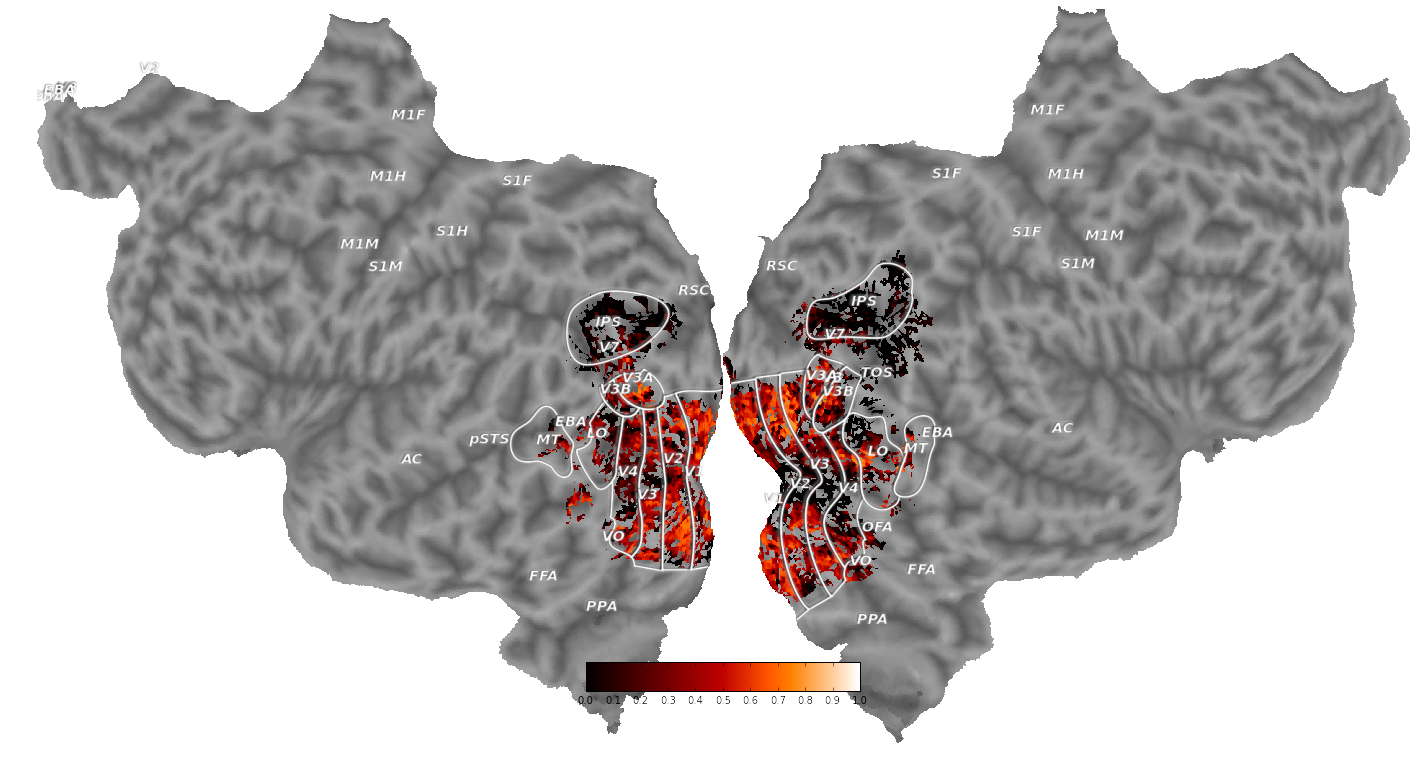

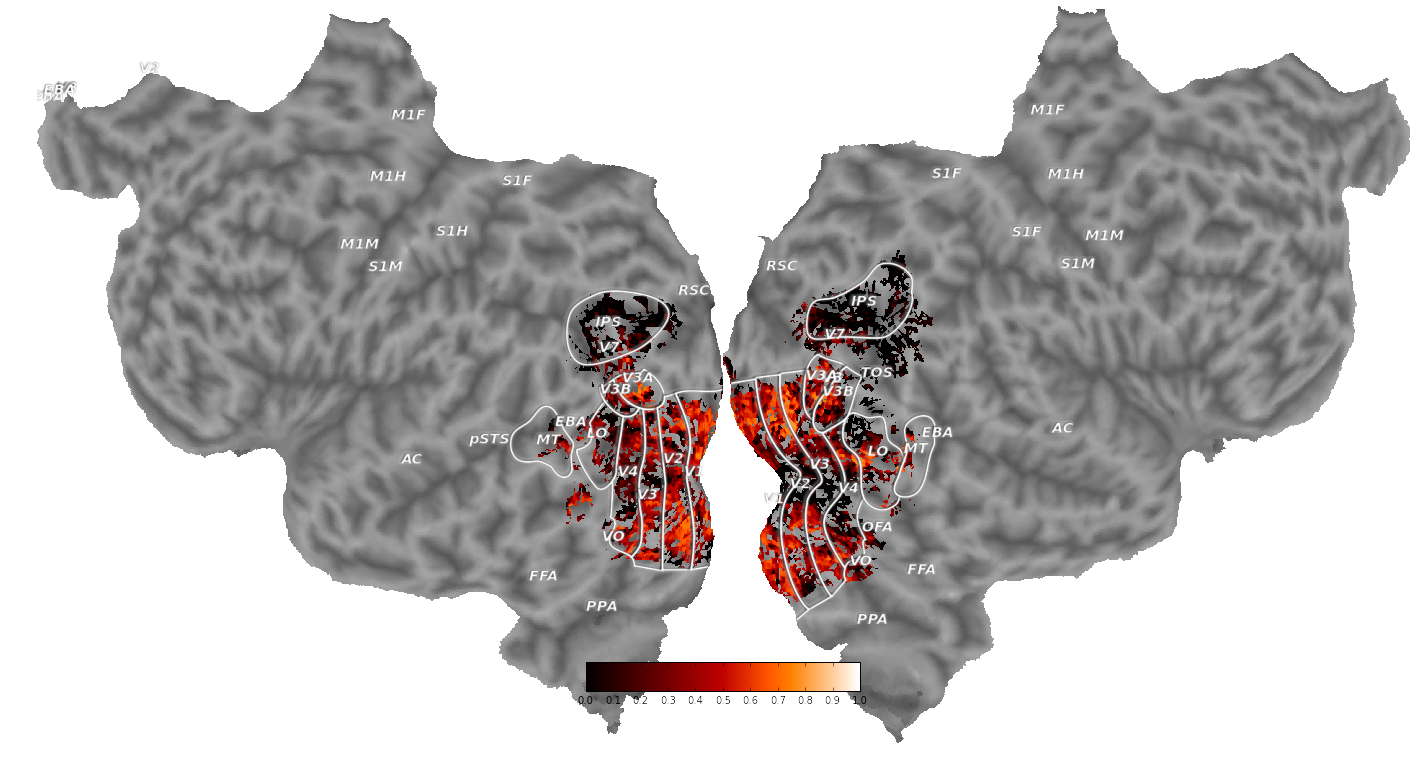

In [13]:
import cortex
from matplotlib import cm
subjName = "S1"
subjTransform = "S1_transform"
corrvol = np.zeros(datasize)
corrvol[roimat] = cca.corrs[0]
# Mask out brain regions that weren't scanned
corrvol[corrvol==0] = np.nan
cortex.quickflat.make_figure(cortex.Volume(corrvol, subjName, subjTransform, cmap = cm.gist_heat, vmin = 0., vmax = 1.), with_curvature = True)

##### Canonical weight maps

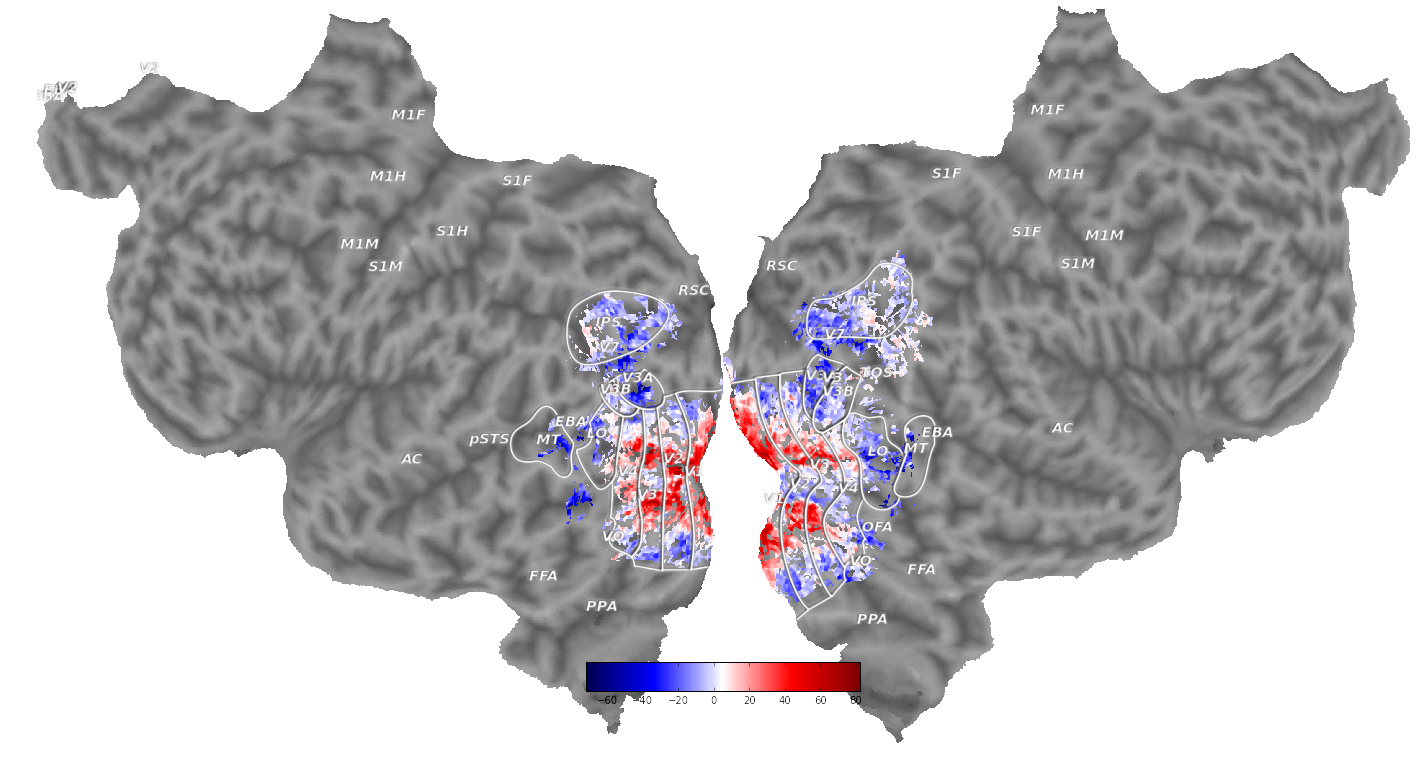

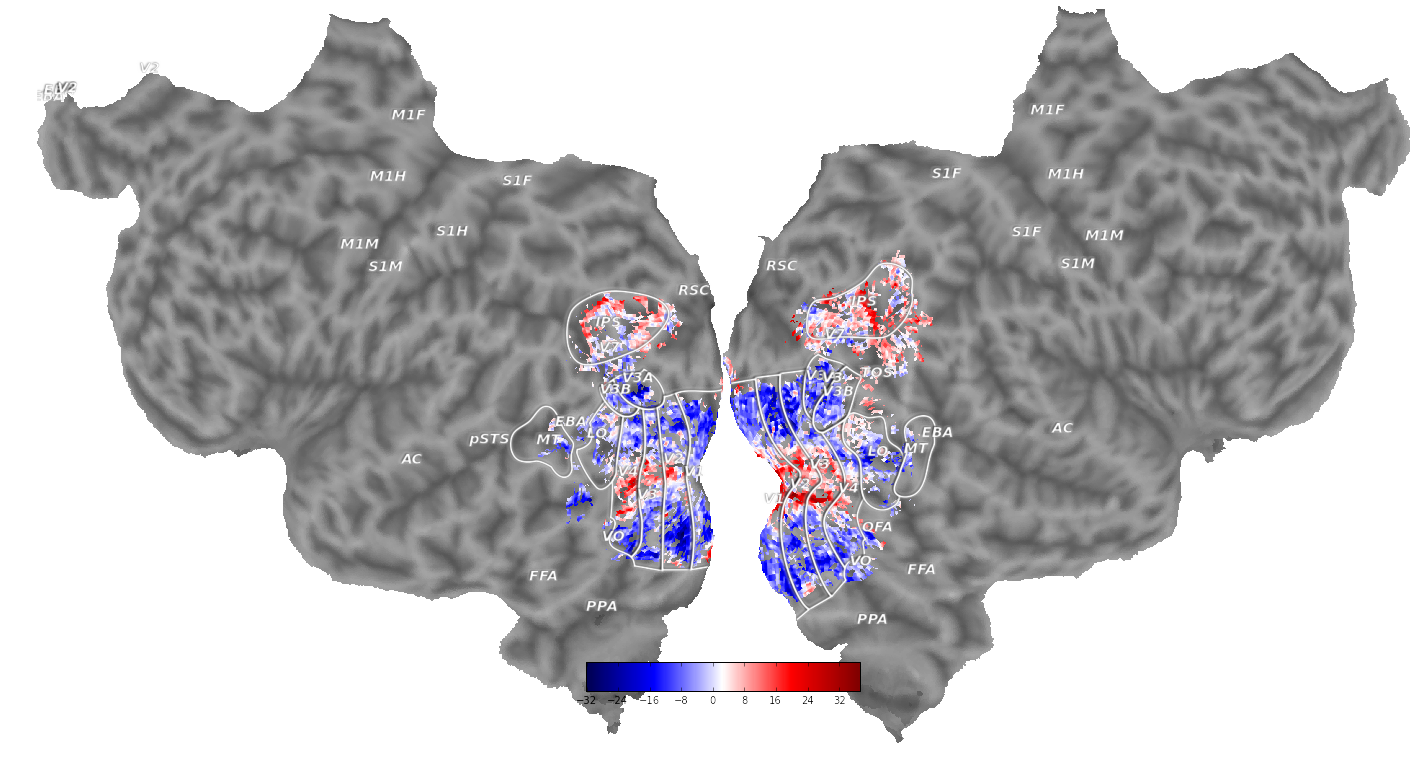

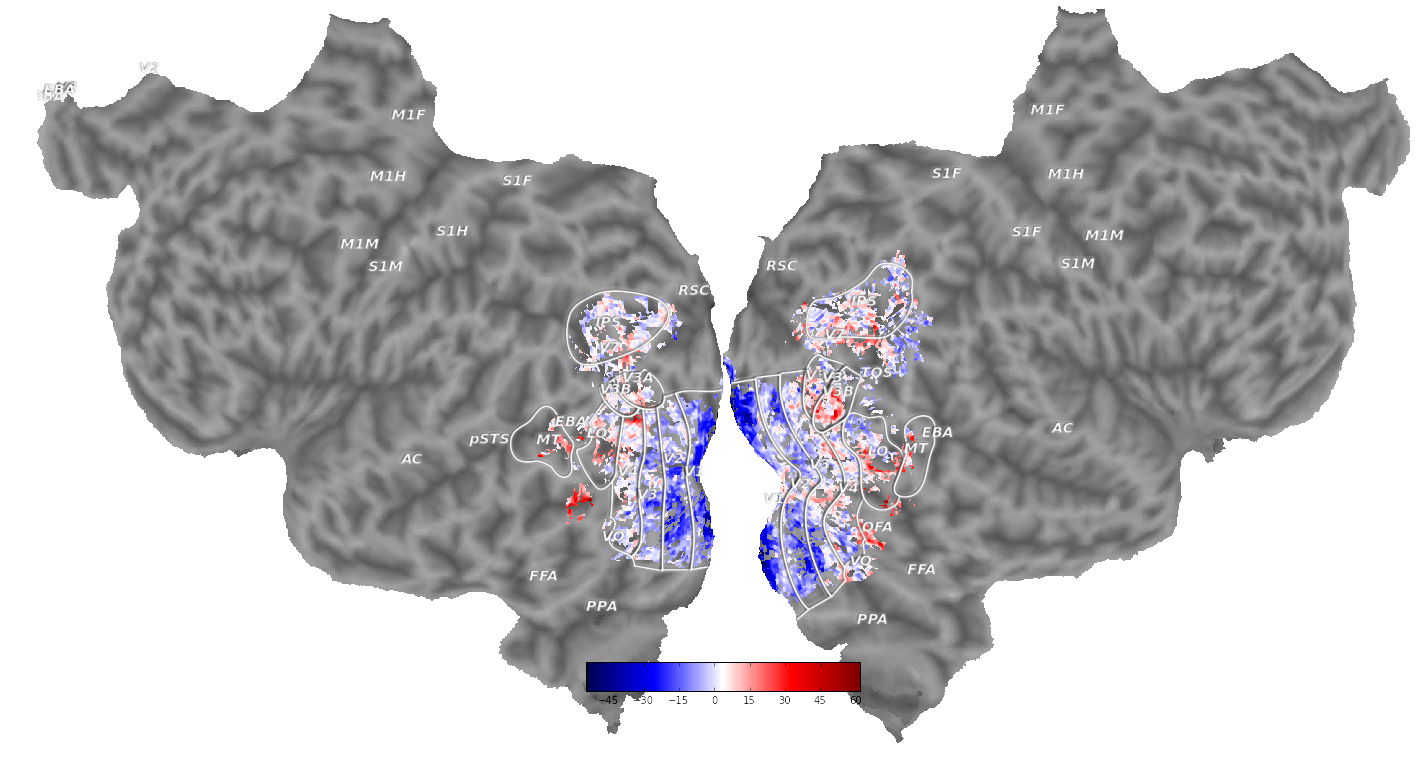

In [14]:
compvol = np.zeros(datasize)
for i in range(cca.best_numCC):
    compvol[roimat] = cca.ws[0].T[i]
    # Mask out brain regions that weren't scanned
    compvol[compvol == 0] = np.nan
    cortex.quickflat.make_figure(cortex.Volume(compvol, subjName, subjTransform, cmap = cm.seismic), with_curvature = True)

##### Variance explained maps

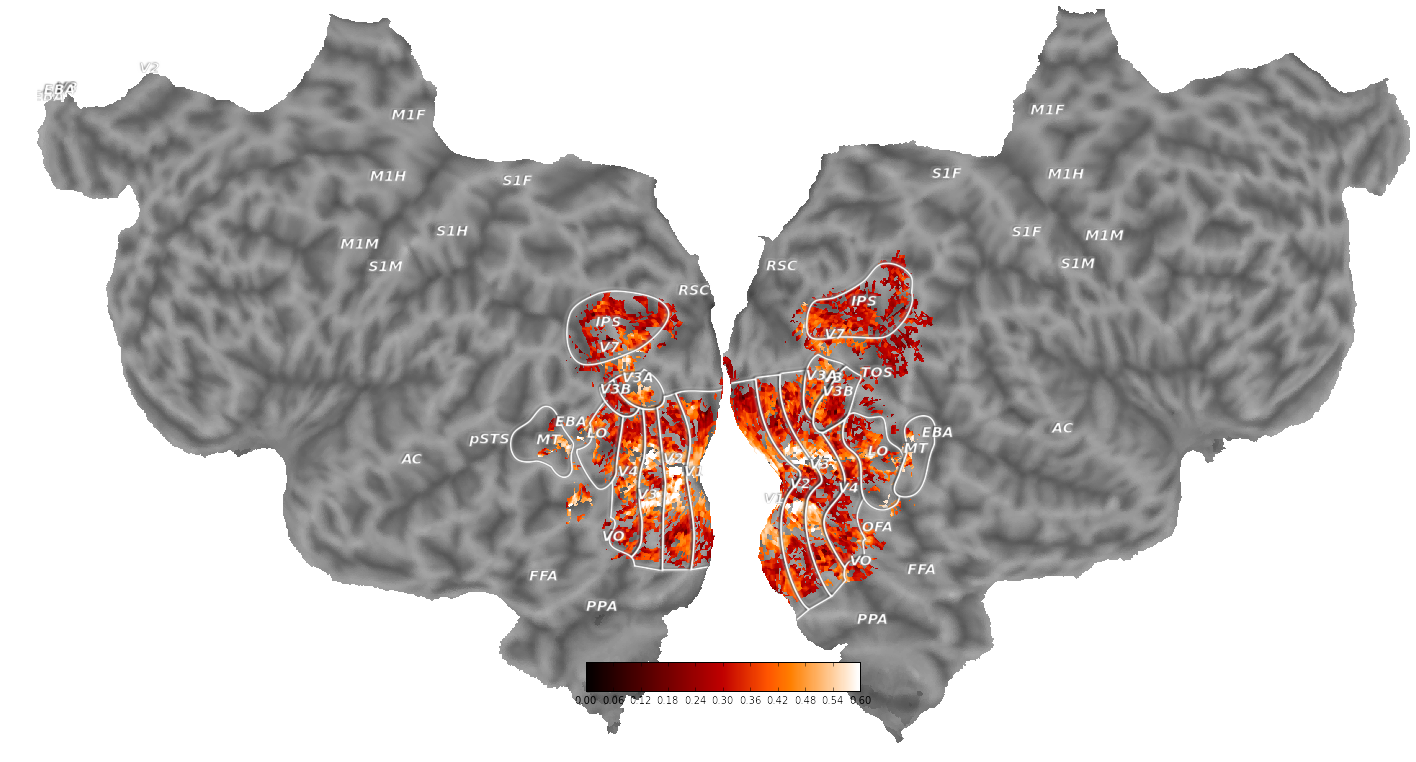

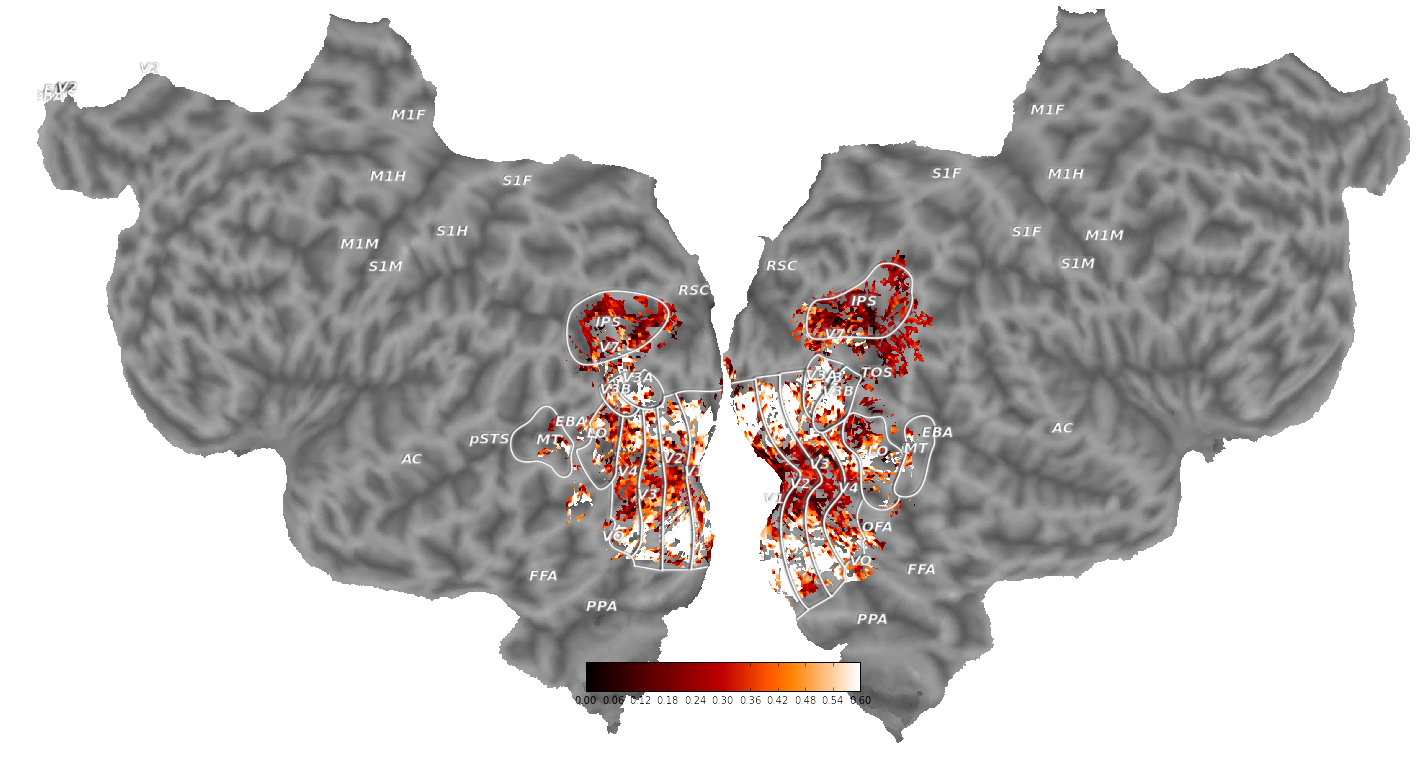

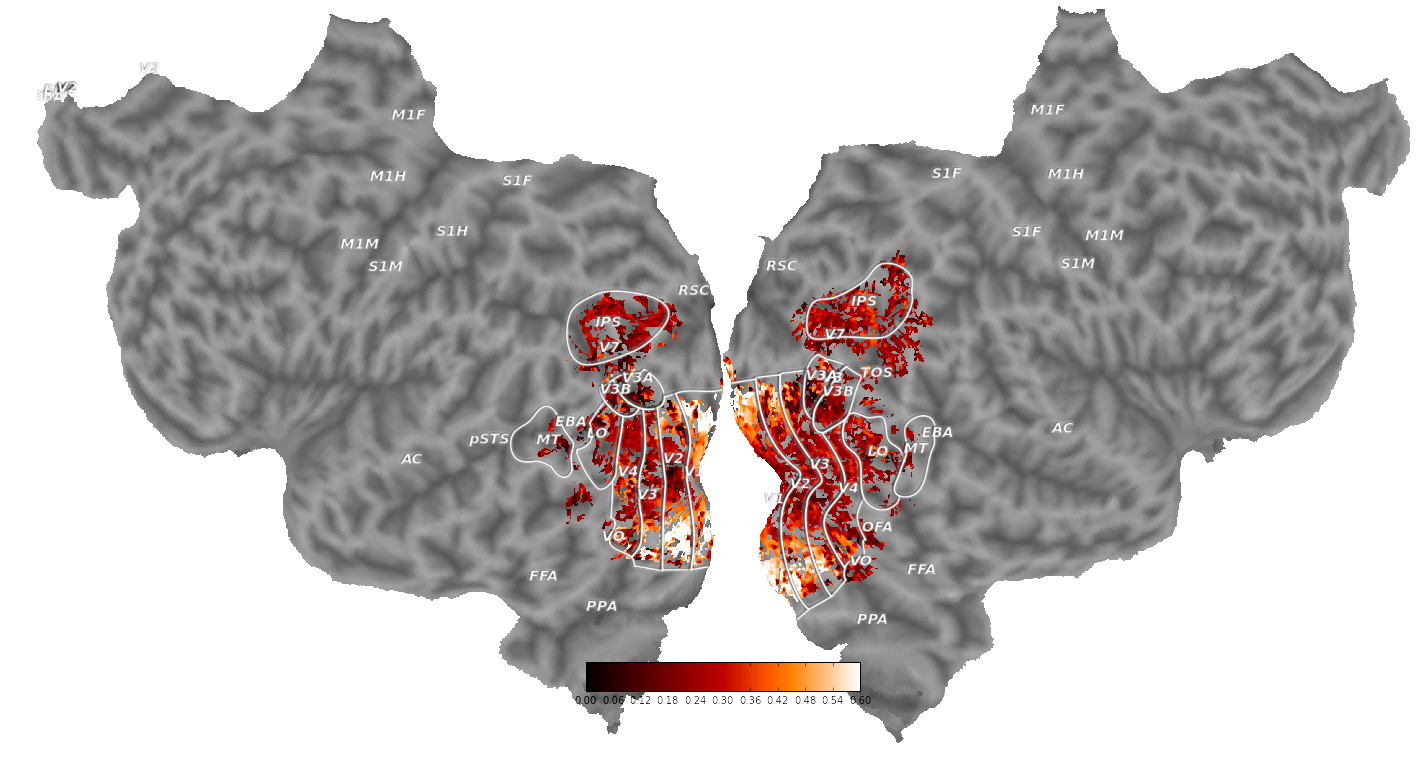

In [15]:
evvol = np.zeros(datasize)
for i in range(cca.best_numCC):
    evvol[roimat] = cca.ev[0][i]
    # Mask out brain regions that weren't scanned
    evvol[evvol == 0] = np.nan
    cortex.quickflat.make_figure(cortex.Volume(evvol, subjName, subjTransform , cmap = cm.gist_heat, vmin = 0., vmax = .6), with_curvature = True)